<a href="https://colab.research.google.com/github/krislars/R-uncertainty/blob/master/MonteCarloModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import random
import numpy as np
import numpy.random as npRand
from matplotlib import pyplot as plt
import scipy.stats as stats

In [52]:
%matplotlib inline

Data file format is intrinsic stellar H-K, sigma H-K, J-H, sigma J-H ... 
Davenport, J. R., Ivezic, Z., Becker, A. C., Ruan, J. J., Hunt-Walker, N. M., Covey, K. R., & Lewis, A. R. (2014, June). The SDSS-2MASS-WISE 10-dimensional stellar colour locus [Electronic version]. MNRAS, 440(4), 3430-3438.

In [53]:
starData = np.loadtxt("https://raw.githubusercontent.com/krislars/R-uncertainty/master/Astro%20Lab%20Star%20Data.txt")
starData = np.transpose(starData)
B, dB = starData[0], starData[1]
D, dD = starData[2], starData[3]

This next line is propagation of error in an arithmetic function.

In [54]:
#calculating theoretical dR
dR = 1.6 *(dB**2 + .02**2 + 1.6 *(dD**2 + .02**2))**0.5

This function takes a vector of values and a vector of associated uncertainties and returns an array of n = numVals samples selected randomly from a normal  probability distribution.

In [55]:
#choosing random data sets for each star type
def getData(mean, sigma, numVals):
    data = np.array(
        [npRand.normal(m, s, numVals) for m, s in zip(mean, sigma)]
    )
    return data

In [56]:
B_vals = getData(B, dB, 1000)
D_vals = getData(D, dB, 1000)

$$
R = \frac{A-B}{C-D}
$$

We will choose values such that the numerator is 1.  So, $A=1+B$.  We also choose the value of R to be 1.6, so $C-D=1/1.6$.  Therefore, $C = 1/1.6+D$.



In [57]:
diffAB = 1
A = diffAB + B
C = diffAB/1.6 + D
dA = dC = np.linspace(0.02, 0.02, 50)
A_vals = getData(A, dA, 1000)
C_vals = getData(C, dC, 1000)

In [58]:
#calculating the "Monte Carlo" values for R and dR
R_vals = (A_vals - B_vals) / (C_vals - D_vals)


Now, we can test the distributions of R.

In [59]:
R_mc = np.mean(R_vals, axis=1)
dR_mc = np.std(R_vals, axis=1)

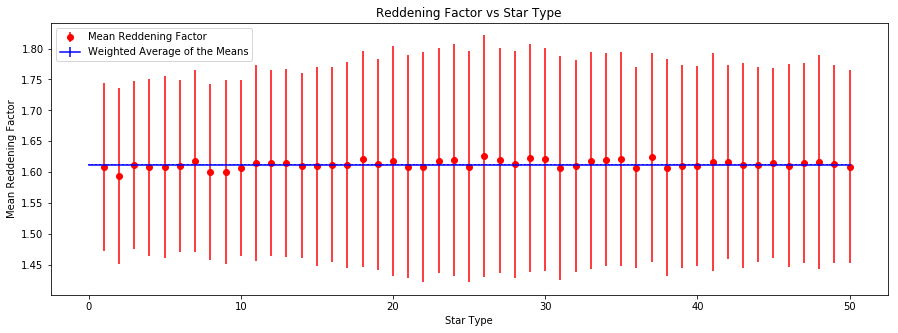

In [68]:
#Finding the weighted average of R
w = (dR_mc)**(-2)
R_avg = sum(w*R_mc) / sum(w)
dR_avg = (sum(w))**-1

t = np.linspace(0, 50, 200)
x = np.linspace(1, 50)
y = np.linspace(R_avg, R_avg, 200)

plt.figure(figsize=(15, 5))
line1 = plt.errorbar(x, R_mc, yerr=dR_mc, fmt='ro', label='1')
line2 = plt.errorbar(t, y, dR_avg, fmt='b-', label='2')

plt.title('Reddening Factor vs Star Type')
plt.xlabel('Star Type')
plt.ylabel('Mean Reddening Factor')
plt.gca().legend(('Mean Reddening Factor', 'Weighted Average of the Means'), loc = 'upper left')

plt.show()

Ideas going forward:
* Calculate the uncertainty in the mean.
* Try a weighted mean
* Try making all the errors the same
* Try making the errors very small
* Test that you are resetting the random number *seed* 



In [61]:
#Next I need to test "Goodness of fit"
numBins = 20
counts, Bins = zip(*np.stack(
    np.histogram(r_vals, numBins) for r_vals in R_vals
))
    

#calc expected with stats cdf and np.diff
exp = np.diff(np.stack(
    stats.norm.cdf(bins, r_mc, dr_mc) for bins, r_mc, dr_mc in zip(Bins, R_mc, dR_mc)
))

#scale expected percentages by sample size
exp = 1000 * exp

#Now calculate the Chi^2 values:
chi2 = np.sum(( (counts - exp)**2 / exp), axis=1)


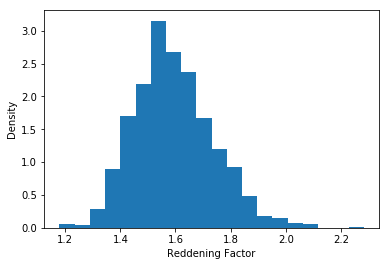

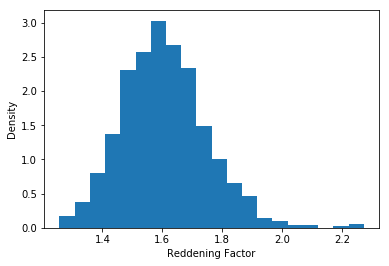

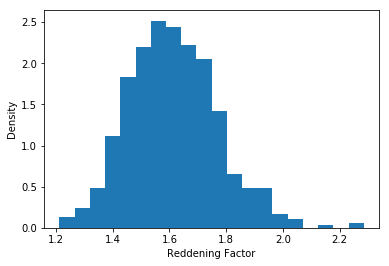

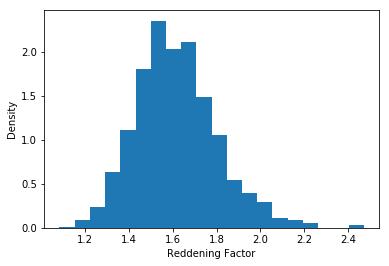

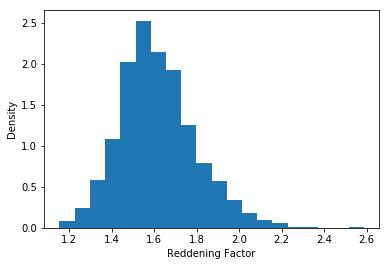

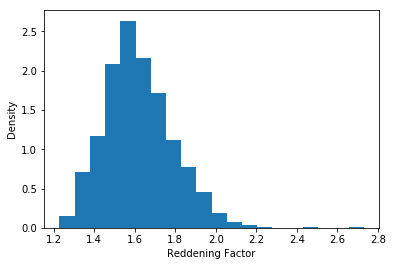

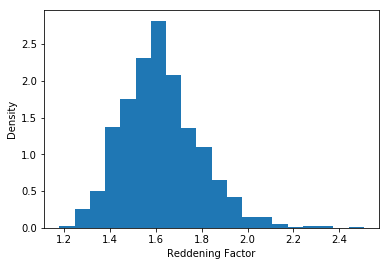

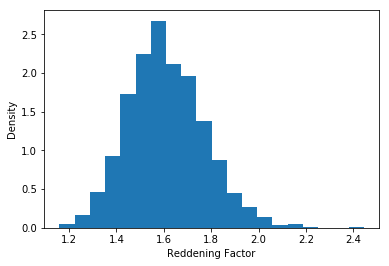

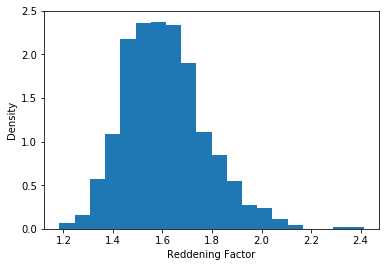

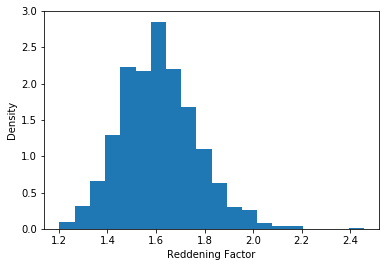

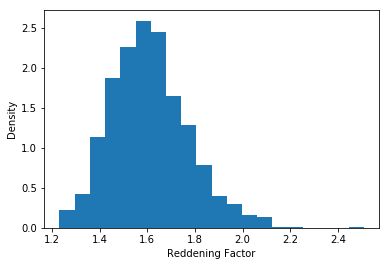

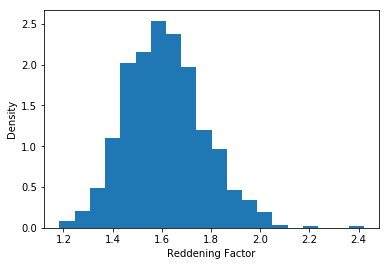

[1, 3, 10, 19, 22, 34, 36, 39, 42, 43, 45, 48]

In [63]:
#Plotting data sets with large Chi^2; looking for outliers
red_chi2 = chi2/numBins

dataToCheck = []
for i in range(len(chi2)):
    if red_chi2[i] > 10:
        dataToCheck.append(i)

for i in dataToCheck:
    plt.hist(R_vals[i], Bins[i], density=True)
    plt.xlabel("Reddening Factor")
    plt.ylabel("Density")
    plt.show()

dataToCheck